In [103]:
from solution import Contestant
from solution import ContestantState
from solution import Coord
from solution import Direction
from solution import Entity
from solution import EntityKind
from solution import GameState


# For testing with Jupyter
def read_game_state_from_file(path: str) -> tuple[int, int, GameState]:
    # Read entities and cache by uid without refrence to root or parent
    with open(path, "r") as buffer:
        width, height = [int(i) for i in buffer.readline().strip().split()]
        
        tmp_entities: dict[
            int, tuple[Entity, int | None, int | None]
        ] = {}  # uid: (entity, parent_uid, root_uid)
        for idx in range(int(buffer.readline().strip())):
            (
                _x,
                _y,
                _kind,
                _owner,
                _uid,
                _dir,
                _parent_uid,
                _root_uid,
            ) = buffer.readline().strip().split()

            _tmp_uid = int(_uid) if int(_uid) else (-idx)
            tmp_entities[_tmp_uid] = (
                Entity(
                    uid=_tmp_uid,
                    x=int(_x),
                    y=int(_y),
                    kind=EntityKind(_kind),
                    owner=None if _owner == "-1" else Contestant(_owner),
                    direction=Direction(_dir),
                    root=None,
                    parent=None,
                ),
                None if int(_parent_uid) == -1 else int(_parent_uid),
                None if int(_root_uid) == -1 else int(_root_uid),
            )

        # Process entities
        entities: dict[Coord, Entity] = {}
        roots: dict[Contestant, Entity] = {}

        for entity, parent_uid, root_uid in tmp_entities.values():
            if parent_uid:
                entity = entity.update_parent(tmp_entities[parent_uid][0])
            if root_uid:
                entity = entity.update_root(tmp_entities[root_uid][0])

            entities[entity.coord] = entity
            if entity.kind == EntityKind.ROOT and entity.owner:
                roots[entity.owner] = entity

        my_a, my_b, my_c, my_d = [int(i) for i in buffer.readline().strip().split()]
        player_state = ContestantState(
            root=roots[Contestant.PLAYER],
            protein_a=my_a,
            protein_b=my_b,
            protein_c=my_c,
            protein_d=my_d,
        )

        opp_a, opp_b, opp_c, opp_d = [int(i) for i in buffer.readline().strip().split()]
        opponent_state = ContestantState(
            root=roots[Contestant.OPPONENT],
            protein_a=opp_a,
            protein_b=opp_b,
            protein_c=opp_c,
            protein_d=opp_d,
        )

        required_actions_count = int(buffer.readline().strip())

        return width, height, GameState(
            player=player_state,
            opponent=opponent_state,
            entities=entities,
            actions=required_actions_count,
        )
    
width, height, game_state = read_game_state_from_file("./inputs/wood_3.txt")

In [99]:
from collections import defaultdict, deque

from solution import DIRECTION_VECTORS

entities, player, opponent = game_state.entities, game_state.player, game_state.opponent

""" Step 1: build adjacency list from map """
adjacency: defaultdict[Coord, set[Coord]] = defaultdict(set)
adj_unvisited_coords: deque[Coord] = deque([player.root.coord])
adj_visited_coords: set[Coord] = set()

while adj_unvisited_coords:
    coord = adj_unvisited_coords.popleft()

    if coord in adj_visited_coords:
        continue

    for direction, (i, j) in DIRECTION_VECTORS.items():
        nx, ny = coord[0] + i, coord[1] + j
        ncoord = (nx, ny)
        entity = entities.get(ncoord)

        if any((
            nx < 0 or nx >= width, 
            ny < 0 or ny >= height, 
            entity and entity.kind == EntityKind.WALL
        )):
            continue

        # Only add to adjacency list if its not already there
        if ncoord not in adjacency:
            adjacency[ncoord].add(coord)

        adj_unvisited_coords.appendleft(ncoord)
    adj_visited_coords.add(coord)

print()
for key, value in adjacency.items():
    print(f'{key} -> {value}')

Visiting (1, 2) ...
 > Checking N at (1, 1) ...
  > Is wall
 > Checking W at (1, 3) ...
  > Adding (1, 3) to adjacency list for (1, 2)
 > Checking E at (2, 2) ...
  > Adding (2, 2) to adjacency list for (1, 2)
 > Checking S at (0, 2) ...
  > Is wall
Visiting (2, 2) ...
 > Checking N at (2, 1) ...
  > Is wall
 > Checking W at (2, 3) ...
  > Adding (2, 3) to adjacency list for (2, 2)
 > Checking E at (3, 2) ...
  > Adding (3, 2) to adjacency list for (2, 2)
 > Checking S at (1, 2) ...
  > Adding (1, 2) to adjacency list for (2, 2)
Visiting (1, 2) ...
 > Already visited
Visiting (3, 2) ...
 > Checking N at (3, 1) ...
  > Is wall
 > Checking W at (3, 3) ...
  > Adding (3, 3) to adjacency list for (3, 2)
 > Checking E at (4, 2) ...
  > Adding (4, 2) to adjacency list for (3, 2)
 > Checking S at (2, 2) ...
Visiting (2, 2) ...
 > Already visited
Visiting (4, 2) ...
 > Checking N at (4, 1) ...
  > Is wall
 > Checking W at (4, 3) ...
  > Adding (4, 3) to adjacency list for (4, 2)
 > Checking E 

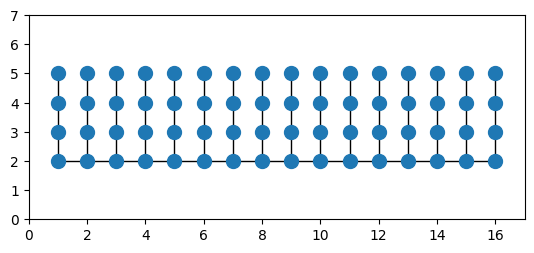

In [100]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(adjacency)

points: set[Coord] = set(adjacency.keys())
for coords in adjacency.values():
    points.update(coords)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots()
nx.draw(G, pos=pos, node_size=100, ax=ax)  # draw nodes and edges
plt.axis("on")
ax.set_xlim(0, width - 1)
ax.set_ylim(0, height - 1)
ax.set_aspect("equal")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()